# Parkinson's Disease Detection using Wave Drawing

### Importing the required Libraries and packages

In [1]:
import numpy as np
import cv2
import os
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dropout, Activation, Flatten, Concatenate, Add, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import pandas as pd

2025-10-22 08:45:43.590331: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761122744.009860      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761122744.142851      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Loading Dataset with preprocessing

In [2]:
# Define the path to the training and testing directory and the categories (wave dataset)
data_dir = '../input/parkinsons-drawings/wave/training'
data_dir_test = '../input/parkinsons-drawings/wave/testing'
categories = ['healthy', 'parkinson']

# Define a standard size for all images
IMG_SIZE = 128

# Initialize lists to store image data and labels
x_train = []
y_train = []
x_test = []
y_test = []

# Loop through each category (healthy and parkinson)
for i, category in enumerate(categories):
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        # Construct the full image path and read the image in grayscale
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        # Resize the image to our standard size
        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        # Append the RESIZED image array and its label
        x_train.append(resized_img)
        y_train.append(i)
    path = os.path.join(data_dir_test, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        resized_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        x_test.append(resized_img)
        y_test.append(i)
    
# Convert the lists to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Print the shapes to verify
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (72, 128, 128)
Shape of y_train: (72,)
Shape of x_test: (30, 128, 128)
Shape of y_test: (30,)


### Data Distribution

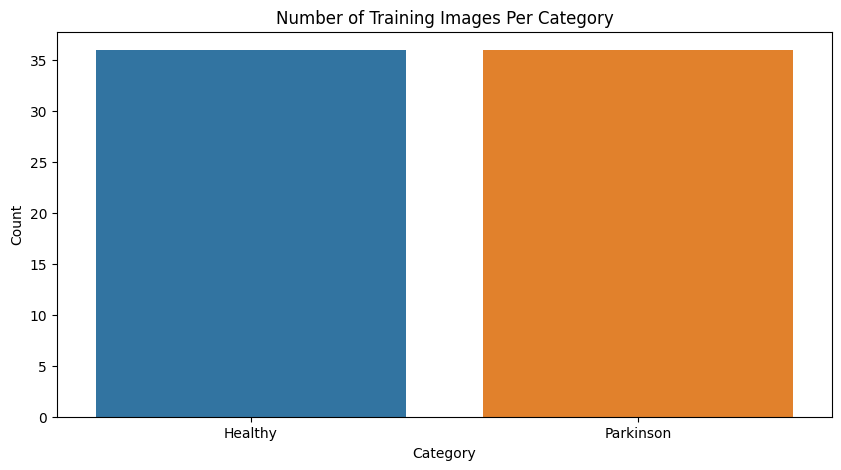

In [3]:
unique_train, count = np.unique(y_train, return_counts=True)
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=unique_train, y=count)
ax.set_title("Number of Training Images Per Category")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
ax.set_xticklabels(['Healthy', 'Parkinson'])
plt.show()

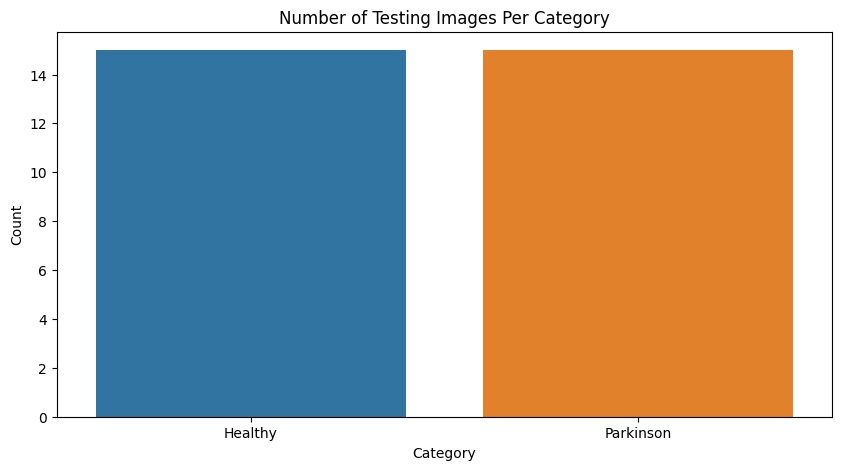

In [4]:
unique_test, count_test = np.unique(y_test, return_counts=True)
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=unique_test, y=count_test)
ax.set_title("Number of Testing Images Per Category")
ax.set_xlabel("Category")
ax.set_ylabel("Count")
ax.set_xticklabels(['Healthy', 'Parkinson'])
plt.show()

As can be seen, though the dataset is balanced but contains very less data points

### Augmenting the Dataset

In [5]:
train_data_generator = ImageDataGenerator(rotation_range=360, width_shift_range=0.0, height_shift_range=0.0, horizontal_flip=True, vertical_flip=True)

x = list(x_train)
y = list(y_train)
x_aug_train = []
y_aug_train = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    # First, add channel dimension (axis=-1), then batch dimension (axis=0)
    x_img = np.expand_dims(x_img, axis=-1) # Shape becomes (128, 128, 1)
    x_img = np.expand_dims(x_img, axis=0)  # Shape becomes (1, 128, 128, 1)
    aug_iter = train_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(70):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_train.append(aug_image)
        y_aug_train.append(v)
        
print("Newly generated x train data: "+str(len(x_aug_train)))
print("Newly generated y train data: "+str(len(y_aug_train)))
x_train = x + x_aug_train
y_train = y + y_aug_train
print("Total x train data: "+str(len(x_train)))
print("Total y train data: "+str(len(y_train)))

test_data_generator = ImageDataGenerator(rotation_range=360, width_shift_range=0.0, height_shift_range=0.0, horizontal_flip=True, vertical_flip=True)

x = list(x_test)
y = list(y_test)
x_aug_test = []
y_aug_test = []

for (i, v) in enumerate(y):
    x_img = x[i]
    x_img = np.array(x_img)
    # First, add channel dimension (axis=-1), then batch dimension (axis=0)
    x_img = np.expand_dims(x_img, axis=-1) # Shape becomes (128, 128, 1)
    x_img = np.expand_dims(x_img, axis=0)  # Shape becomes (1, 128, 128, 1)
    aug_iter = test_data_generator.flow(x_img, batch_size=1, shuffle=True)
    for j in range(20):
        aug_image = next(aug_iter)[0].astype('uint8')
        x_aug_test.append(aug_image)
        y_aug_test.append(v)

print("Newly generated x test data: "+str(len(x_aug_test)))
print("Newly generated y test data: "+str(len(y_aug_test)))
x_test = x + x_aug_test
y_test = y + y_aug_test
print("Total x test data: "+str(len(x_test)))
print("Total y test data: "+str(len(y_test)))

Newly generated x train data: 5040
Newly generated y train data: 5040
Total x train data: 5112
Total y train data: 5112
Newly generated x test data: 600
Newly generated y test data: 600
Total x test data: 630
Total y test data: 630


### Visualizing the Images in Train and Test Set

##### Images in Train Set

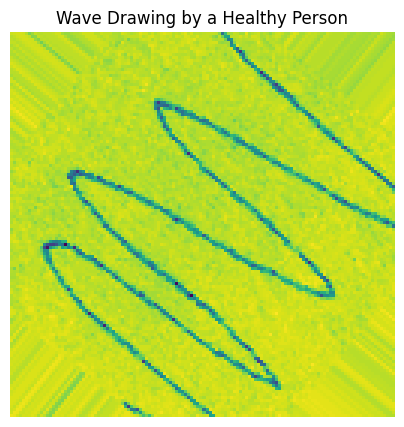

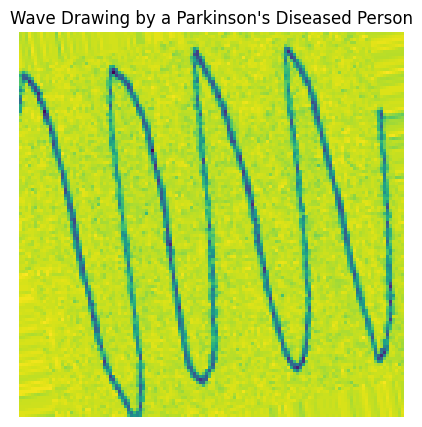

In [6]:
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_train) if v == 0]
img_healthy = x_train[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Wave Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_train) if v == 1]
img_parkinson = x_train[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Wave Drawing by a Parkinson's Diseased Person")
plt.axis('off')
plt.show()

#### Images in Test Set

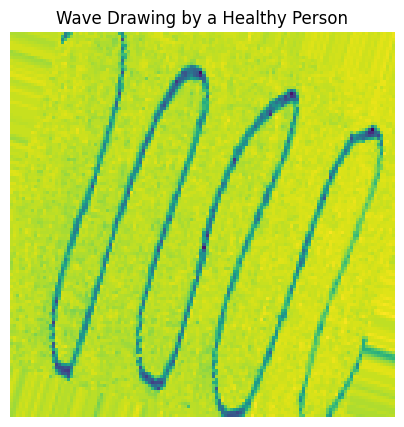

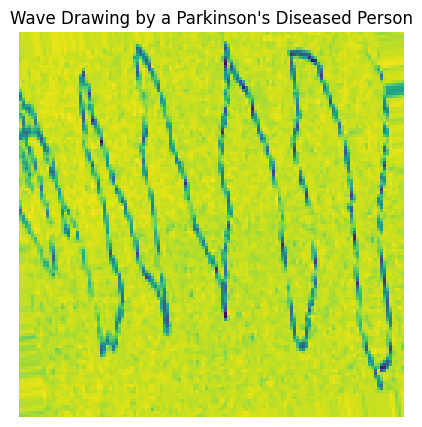

In [7]:
figure1 = plt.figure(figsize=(5, 5))
idx_healthy = [i for (i, v) in enumerate(y_test) if v==0]
img_healthy = x_test[idx_healthy[-1]]
plt.imshow(img_healthy)
plt.title('Wave Drawing by a Healthy Person')
plt.axis('off')
plt.show()

figure2 = plt.figure(figsize=(5, 5))
idx_parkinson = [i for (i, v) in enumerate(y_test) if v==1]
img_parkinson = x_test[idx_parkinson[-1]]
plt.imshow(img_parkinson)
plt.title("Wave Drawing by a Parkinson's Diseased Person")
plt.axis('off')
plt.show()

### Preprocessing the Images

In [8]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
print(y_train.shape)

label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
print(y_test.shape)

(5112,)
(630,)


In [9]:
# Standardize x_train
x_train_standardized = []
for img in x_train:
    if img.ndim == 2:
        # Add a channel dimension to original 2D images
        x_train_standardized.append(np.expand_dims(img, axis=-1))
    else:
        # Keep augmented 3D images as they are
        x_train_standardized.append(img)
x_train = np.array(x_train_standardized)

# Standardize x_test
x_test_standardized = []
for img in x_test:
    if img.ndim == 2:
        x_test_standardized.append(np.expand_dims(img, axis=-1))
    else:
        x_test_standardized.append(img)
x_test = np.array(x_test_standardized)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Print the final shapes
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (5112, 128, 128, 1)
Shape of y_train: (5112,)
Shape of x_test: (630, 128, 128, 1)
Shape of y_test: (630,)


### Defining the Model

In [10]:
# V1
# def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
#     model = Sequential([
#         Input(shape=input_shape),
#         # Block 1: Low-level edge detection
#         Conv2D(32, (3, 3), padding='same', activation='relu', 
#                kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Conv2D(32, (3, 3), padding='same', activation='relu',
#                kernel_initializer='he_normal'),
#         BatchNormalization(),
#         MaxPooling2D((2, 2)),
#         Dropout(0.2),
#         # Block 2: Pattern recognition
#         Conv2D(64, (3, 3), padding='same', activation='relu',
#                kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Conv2D(64, (3, 3), padding='same', activation='relu',
#                kernel_initializer='he_normal'),
#         BatchNormalization(),
#         MaxPooling2D((2, 2)),
#         Dropout(0.3),
#         # Block 3: Complex feature extraction
#         Conv2D(128, (3, 3), padding='same', activation='relu',
#                kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Conv2D(128, (3, 3), padding='same', activation='relu',
#                kernel_initializer='he_normal'),
#         BatchNormalization(),
#         MaxPooling2D((2, 2)),
#         Dropout(0.4),
#         # Global pooling to reduce parameters
#         GlobalAveragePooling2D(),
#         # Classification head
#         Dense(128, activation='relu', kernel_initializer='he_normal'),
#         BatchNormalization(),
#         Dropout(0.5),
#         Dense(64, activation='relu', kernel_initializer='he_normal'),
#         Dropout(0.5),
#         # Binary output
#         Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
#     ])
    
#     # Compile with proper binary classification setup
#     model.compile(
#         optimizer=Adam(learning_rate=0.0001),
#         loss='binary_crossentropy',
#         metrics=[
#             'accuracy',
#             tf.keras.metrics.Precision(name='precision'),
#             tf.keras.metrics.Recall(name='recall'),
#             tf.keras.metrics.AUC(name='auc')
#         ]
#     )
#     return model

In [11]:
def parkinson_disease_detection_model(input_shape=(128, 128, 1)):
    model = Sequential([
        Input(shape=input_shape),
        
        # Block 1
        Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 2
        Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Block 3
        Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Block 4
        Conv2D(256, (3, 3), padding='same', kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
        
        # Dense layers
        Flatten(),
        Dense(256, kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        Dense(128, kernel_initializer='he_normal'),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.5),
        
        # Output
        Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.AUC(name='auc')
        ]
    )
    
    return model

In [12]:
model = parkinson_disease_detection_model(input_shape=(128, 128, 1))
model.summary()

I0000 00:00:1761122771.178223      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761122771.178942      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             

 Total params: 4,813,537 (18.36 MB)

 Trainable params: 4,811,361 (18.35 MB)

 Non-trainable params: 2,176 (8.50 KB)

### Training the Model

In [13]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=5, stratify=y_train)

In [14]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=100):
    # Define callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-7,
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model_vgg_wave.h5',
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=1
        )
    ]
    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=callbacks,
        verbose=1
    )
    return history

In [15]:
history = train_model(model, X_train, y_train, X_val, y_val, epochs=100)

Epoch 1/100


I0000 00:00:1761122783.825667     105 service.cc:148] XLA service 0x7f094800c090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761122783.826961     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761122783.826982     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1761122784.878854     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/128 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.4922 - auc: 0.4716 - loss: 0.8843 - precision: 0.4167 - recall: 0.3510  

I0000 00:00:1761122796.967845     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.5794 - auc: 0.6051 - loss: 0.7590 - precision: 0.5869 - recall: 0.4911
Epoch 1: val_auc improved from -inf to 0.62881, saving model to best_model_vgg_wave.h5
128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 164ms/step - accuracy: 0.5798 - auc: 0.6057 - loss: 0.7584 - precision: 0.5874 - recall: 0.4917 - val_accuracy: 0.4995 - val_auc: 0.6288 - val_loss: 0.7192 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7959 - auc: 0.8740 - loss: 0.4368 - precision: 0.8305 - recall: 0.7380
Epoch 2: val_auc did not improve from 0.62881
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.7962 - auc: 0.8743 - loss: 0.4363 - precision: 0.8306 - recall: 0.7386 - val_accuracy: 0.4800 - val_auc: 0.4462 - val_loss: 1.1543 - val_precision: 0.4895 - val_recall: 0.9062 - learning_rate: 0.0010
Epoch 3/100
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9037 - auc

### Loss and Accuracy Plot

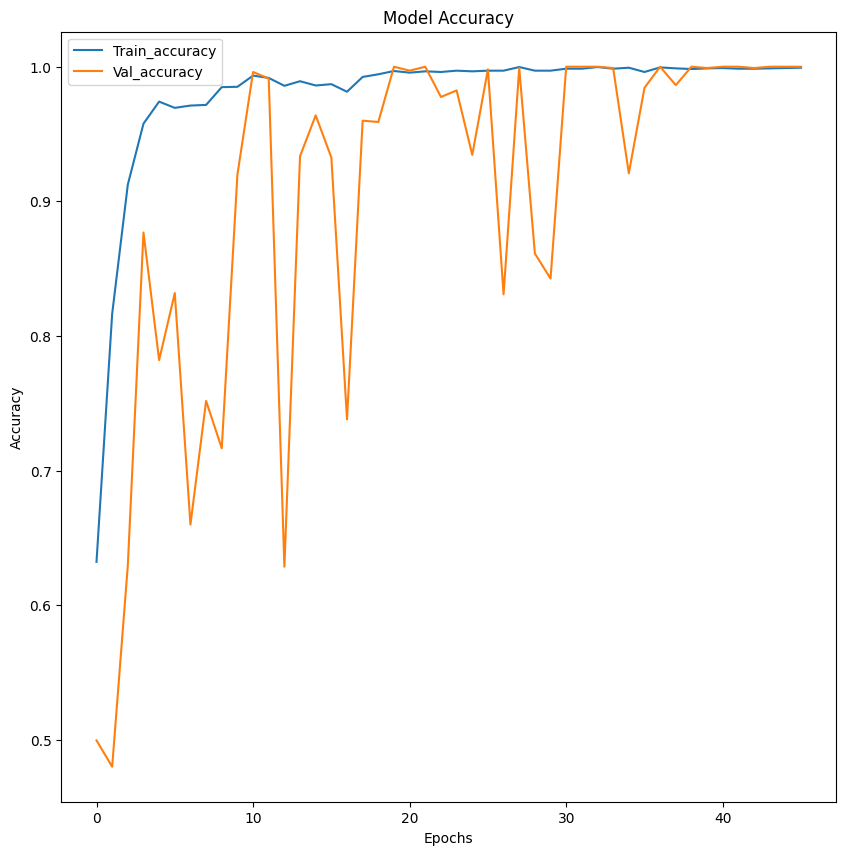

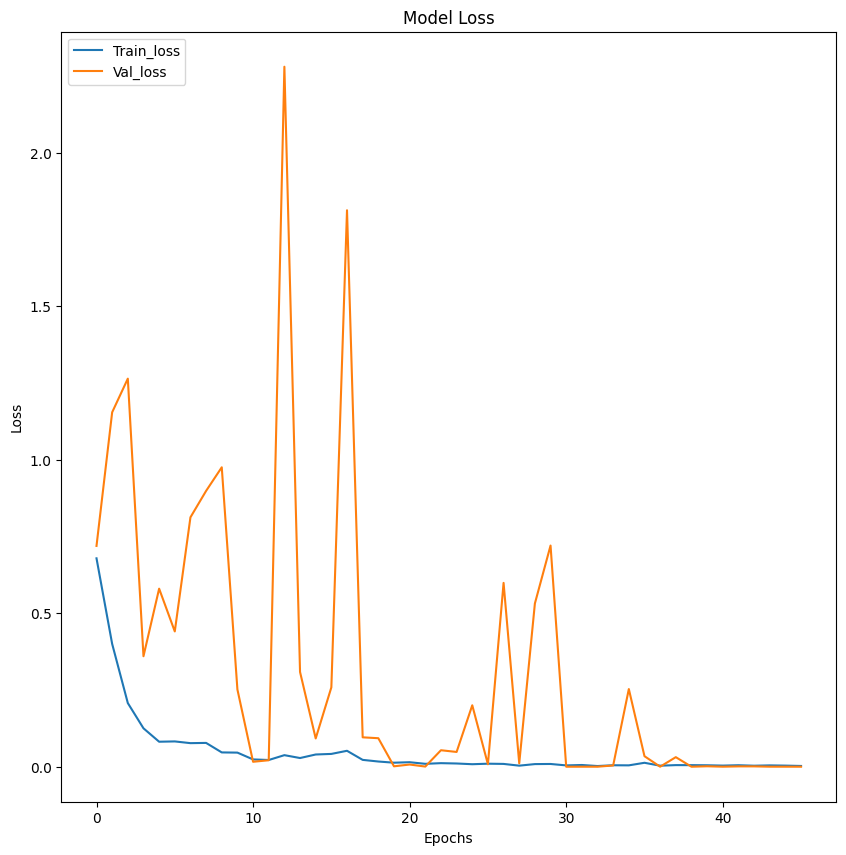

In [16]:
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'], label='Train_accuracy')
plt.plot(history.history['val_accuracy'], label='Val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'], label='Train_loss')
plt.plot(history.history['val_loss'], label='Val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [17]:
def evaluate_predictions(model, X_val, y_val):
    y_pred_probs = model.predict(X_val)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()
    print("PREDICTION ANALYSIS")
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    print(f"Predicted class distribution: {dict(zip(unique_pred, counts_pred))}")
    print(f"\nPrediction probabilities:")
    print(f"  Min: {y_pred_probs.min():.4f}")
    print(f"  Max: {y_pred_probs.max():.4f}")
    print(f"  Mean: {y_pred_probs.mean():.4f}")
    print(f"  Median: {np.median(y_pred_probs):.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred, target_names=['Healthy', 'Parkinson']))

In [18]:
evaluate_predictions(model, X_val, y_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
PREDICTION ANALYSIS
Predicted class distribution: {0: 511, 1: 512}

Prediction probabilities:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.5004
  Median: 0.9924

Confusion Matrix:
[[511   0]
 [  0 512]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00       511
   Parkinson       1.00      1.00      1.00       512

    accuracy                           1.00      1023
   macro avg       1.00      1.00      1.00      1023
weighted avg       1.00      1.00      1.00      1023



### Saving the Model

In [20]:
model.save('parkinson_disease_detection.h5')